# Automatizovana segmentacija EKG signala dubokom neuralnom mrežom

## Univerzitet Lobačevski EKG baza
Lobachevsky University Electrocardiography Database (LUDB)

Kalyakulina, A., Yusipov, I., Moskalenko, V., Nikolskiy, A., Kosonogov, K., Zolotykh, N., & Ivanchenko, M. (2021). Lobachevsky University Electrocardiography Database (version 1.0.1). PhysioNet. https://doi.org/10.13026/eegm-h675.

Kalyakulina, A.I., Yusipov, I.I., Moskalenko, V.A., Nikolskiy, A.V., Kosonogov, K.A., Osipov, G.V., Zolotykh, N.Yu., Ivanchenko, M.V.: LUDB: A New Open-Access Validation Tool for Electrocardiogram Delineation Algorithms, IEEE Access, vol. 8, pp. 186181-186190, 2020, doi: 10.1109/ACCESS.2020.3029211

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

## Signali

- 12 kanalni EKG
- 200 ispitanika
  - 12 kanala
  - 10 sekundi
- Ekspertske anotacije P, T i QRS kompleksa
- Frekvencija odabiranja 500Hz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
!pip install wfdb
import wfdb
import matplotlib.pyplot as plt
import numpy as np


data_dir = "/content/drive/MyDrive/NM projekat DATA/lobachevsky-university-electrocardiography-database-1.0.1/data"

header_files = [file for file in os.listdir(data_dir) if file.endswith(".hea")]
binary_files = [file for file in os.listdir(data_dir) if file.endswith(".dat")]
annotation_files  = [file for file in os.listdir(data_dir) if not (file.endswith(".dat") or file.endswith(".hea"))]
leads = set([file.split('.')[1] for file in annotation_files])
patients = list(set([file.split('.')[0] for file in annotation_files]))

fs = 500

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Prikaz jednog odvoda sa anotacijama

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

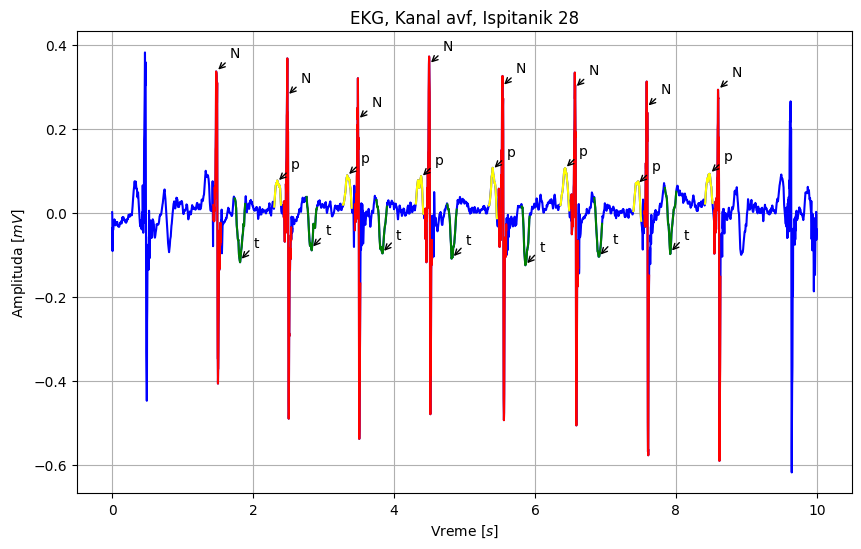

In [ ]:
# Signal
patient = random.choice(patients)

patient_annotations = [file for file in annotation_files if file.startswith(patient)]
record = wfdb.rdsamp(os.path.join(data_dir, patient))

lead = random.choice(patient_annotations).split('.')[1]

annotation = wfdb.rdann(os.path.join(data_dir, f"{patient}"), lead)
symbols = annotation.symbol[1::3]
stamps = annotation.sample #begin, mark, end

signal_index = record[1]['sig_name'].index(lead)
signal = record[0][:,signal_index]
unit = record[1]['units'][signal_index]

# Crtanje
time = [i / fs for i in range(5000)]

plt.figure(figsize=(10, 6))
plt.plot(time, signal, color='blue')

color_map = {'N': 'red', 't': 'green', 'p': 'yellow'}

for i, txt in enumerate(symbols):
    start_index = stamps[i * 3]
    end_index = stamps[2 + i * 3]
    plt.plot(time[start_index:end_index], signal[start_index:end_index], color = color_map.get(txt, 'black'), label=txt)
    plt.annotate(txt, (time[stamps[1 + i * 3]], signal[stamps[1 + i * 3]]), xytext=(10, 10),
                    textcoords='offset points', arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title(f"EKG, Kanal {lead}, Ispitanik {patient}")
plt.xlabel("Vreme [${s}$]")
plt.ylabel(f"Amplituda [${unit}$]")
plt.grid(True, which='both')
plt


### Balansiranost

Baza sadrži: 16797 P talasa, 21966 QRS kompleksa, 19666 T talasa (ukupno 58429).
Dužina kompleksa odnosno talasa je srazmerna njegovoj apriornoj verovatnoći pojavljivanja.

Početak i kraj svakog kanala nemaju anotaciju zato će svaki signal biti skraćen. Početak će biti unifromno izabran od 2s do 3s, a dužina će biti fiksna 5s.

In [ ]:
signals = np.zeros((fs*5, 10*len(leads) * len(patients)))
labels = np.zeros((fs*5,  10*len(leads) * len(patients)))

total_annotations = [0, 0, 0]

for augmentation in range(10):
  # Progress tracker
  print(augmentation)
  for patient in patients:
    record = wfdb.rdsamp(os.path.join(data_dir, patient))

    for lead in leads:
      annotation = wfdb.rdann(os.path.join(data_dir, f"{patient}"), lead)
      symbols = annotation.symbol[1::3]
      stamps  = annotation.sample #begin, mark, end

      label = np.zeros((5000,1))

      for i in range(len(symbols)):
        start_index = stamps[i * 3]
        end_index = stamps[min(2 + i * 3, len(stamps)-1)]
        mark = 0
        if symbols == 'p':
          mark = 1
        elif symbols == 'N':
          mark = 2
        elif symbols == 't':
          mark = 3
        label[start_index:end_index] = np.array([mark for _ in range(end_index - start_index)]).reshape((end_index - start_index,1))

      start_index = random.randint(fs*2+1, fs*3)
      labels[:,augmentation*len(leads) * len(patients) + (int(patient)-1)*len(leads)+list(leads).index(lead)] = np.array(label[start_index:(start_index + fs*5)]).reshape((fs*5))
      signal_index = record[1]['sig_name'].index(lead)
      signal = record[0][:,signal_index]
      signals[:,augmentation*len(leads) * len(patients)+(int(patient)-1)*len(leads)+list(leads).index(lead)] = signal[start_index:start_index + fs*5]

      current_annotations = [symbols.count('p'), symbols.count('N'), symbols.count('t')]
      total_annotations = [total + current for total, current in zip(total_annotations, current_annotations)]

0
1
2
3
4
5
6
7
8
9


### Čuvanje podataka

Od svakog signala random crop metodom je dobijeno 10 augmentiranih signala.

In [ ]:
import os.path

data_dir = "/content/drive/MyDrive/NM projekat DATA/lobachevsky-university-electrocardiography-database-1.0.1"

signals_file_path = os.path.join(data_dir, 'signals.npy')
if not os.path.exists(signals_file_path):
    np.save(signals_file_path, signals)
    print("Signals file saved successfully.")
else:
    print("Signals file already exists. Not overwriting.")

labels_file_path = os.path.join(data_dir, 'labels.npy')
if not os.path.exists(labels_file_path):
    np.save(labels_file_path, labels)
    print("Labels file saved successfully.")
else:
    print("Labels file already exists. Not overwriting.")

total_annotations_file_path = os.path.join(data_dir, 'total_annotations.npy')
if not os.path.exists(total_annotations_file_path):
    np.save(total_annotations_file_path, total_annotations)
    print("Total annotations file saved successfully.")
else:
    print("Total annotations file already exists. Not overwriting.")


Signals file saved successfully.
Labels file saved successfully.
Total annotations file saved successfully.


In [18]:
data_dir = "/content/drive/MyDrive/NM projekat DATA/lobachevsky-university-electrocardiography-database-1.0.1"

signals = np.load(os.path.join(data_dir, 'signals.npy'))
labels = np.load(os.path.join(data_dir, 'labels.npy'))
total_annotations = np.load(os.path.join(data_dir, 'total_annotations.npy'))

print('Broj pojedinačnih talasa: ', total_annotations)

Broj pojedinačnih talasa:  [167780 217990 195140]


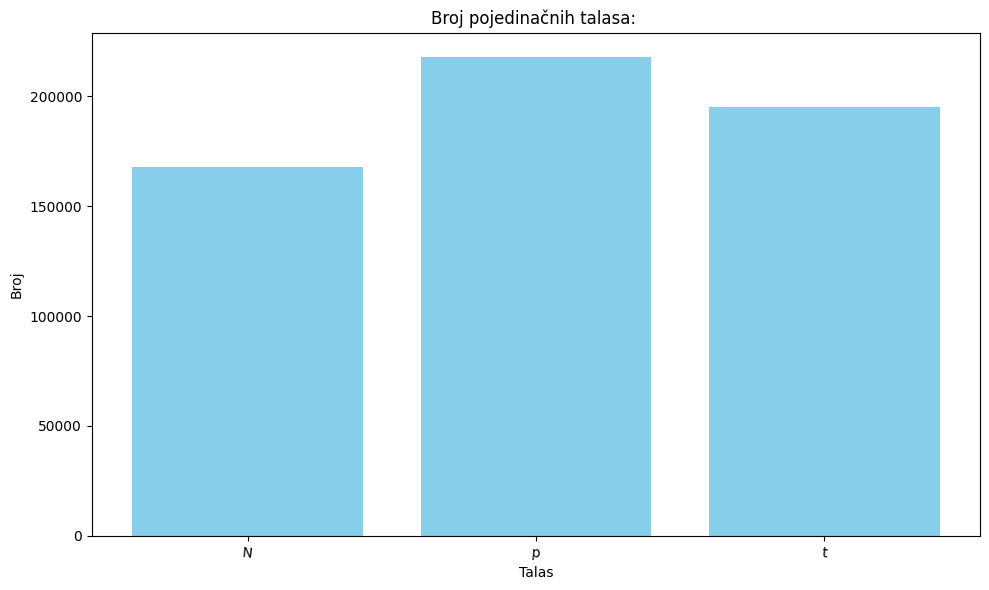

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(np.unique(symbols), total_annotations, color='skyblue')
plt.xlabel('Talas')
plt.ylabel('Broj')
plt.title('Broj pojedinačnih talasa: ')
plt.xticks(rotation=-5)
plt.tight_layout()
plt.show()

### Podela podataka

Podatke delimo na nezavisne skupove:
1. Test 30%, za testiranje mreže
2. Trening 60%, za treniranje mreže
3. Validacioni 10%, sprečava preobučavanje (rano zaustavljanje)


Kako je u pitanju segmentacija nemoguće je razdvojiti kanale, ali se treba truditi da pojedinačni odvodi istog ispitanika budu raspoređeni u sva tri skupa, jer su zavisni.

U daljem izlaganju studenti se u velikoj meri oslanjaju na rad:

*Moskalenko, V., Zolotykh, N., & Osipov, G. (2020). Deep learning for ECG segmentation. In Advances in Neural Computation, Machine Learning, and Cognitive Research III: Selected Papers from the XXI International Conference on Neuroinformatics, October 7-11, 2019, Dolgoprudny, Moscow Region, Russia (pp. 246-254). Springer International Publishing.*

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

signals_train, signals_test, labels_train, labels_test = train_test_split(signals.T, labels.T, test_size=0.3, shuffle=True, random_state=42)

signals_train, signals_val, labels_train, labels_val = train_test_split(signals_train, labels_train, test_size=1/7, shuffle=True, random_state=42)

if signals_train.shape == labels_train.shape:
  print("Trening skup:", signals_train.shape)
if signals_val.shape == labels_val.shape:
  print("Validacioni skup:", signals_val.shape)
if signals_test.shape == labels_test.shape:
  print("Test skup:", signals_test.shape)

labels_train = to_categorical(labels_train, num_classes=4)
labels_test = to_categorical(labels_test, num_classes=4)
labels_val = to_categorical(labels_val, num_classes=4)

Trening skup: (14400, 2500)
Validacioni skup: (2400, 2500)
Test skup: (7200, 2500)
Test skup: (2400, 2500, 4)


### Arhitektura neuralne mreže
Arhitektura je slična UNet arhitekturi.
- Ulaz je signal dužine 5*fs = 2500
- Izlaz je oblika 4x2500 gde svaki od 4 kanala predstavlja verovatnoću jedne od klasa (argmax)
- Postoje četiri početna sekvencijalna bloka, jedan među blok i četiri krajnja sekvencijalna bloka, koja prethode singularnom konvolucionom bloku:
  1. Početni blok se sastoji iz dvostrukog sloja konvolucije, batch normalizacije i ReLU aktivacione funkcije.
  Ulaz

In [53]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import ZeroPadding1D

def conv_block(input_tensor, num_filters):
    encoder = layers.Conv1D(num_filters, 9, padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv1D(num_filters, 9, padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def downsample_block(input_tensor, num_filters):
    encoder_pool = layers.MaxPooling1D(2)(input_tensor)
    encoder = conv_block(encoder_pool, num_filters)
    return encoder_pool, encoder

def upsample_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv1DTranspose(num_filters, 8, strides=2, padding='same')(input_tensor)
    padding_amount = decoder.shape[1] - concat_tensor.shape[1]
    concat_tensor = ZeroPadding1D(padding=(0, padding_amount))(concat_tensor)

    decoder = layers.concatenate([concat_tensor, decoder], axis=2)
    decoder = conv_block(decoder, num_filters)
    return decoder

def unet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    encoder0_pool, encoder0 = downsample_block(inputs, 4)
    encoder1_pool, encoder1 = downsample_block(encoder0, 8)
    encoder2_pool, encoder2 = downsample_block(encoder1, 16)
    encoder3_pool, encoder3 = downsample_block(encoder2, 32)

    bottleneck = conv_block(encoder3, 64)

    decoder3 = upsample_block(bottleneck, encoder3, 32)
    decoder2 = upsample_block(decoder3, encoder2, 16)
    decoder1 = upsample_block(decoder2, encoder1, 8)
    decoder0 = upsample_block(decoder1, encoder0, 4)

    padding_amount = 2500 - decoder0.shape[1]
    decoder0 = ZeroPadding1D(padding=(0, padding_amount))(decoder0)
    outputs = layers.Conv1D(4, 1, activation='sigmoid')(decoder0)

    # Create model
    model = tf.keras.Model(inputs, outputs)
    return model

input_shape = signals_train.shape
model = unet((input_shape[-1], 1))
model.summary()

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics='accuracy')


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 2500, 1)]            0         []                            
                                                                                                  
 max_pooling1d_84 (MaxPooli  (None, 1250, 1)              0         ['input_27[0][0]']            
 ng1D)                                                                                            
                                                                                                  
 conv1d_325 (Conv1D)         (None, 1250, 4)              40        ['max_pooling1d_84[0][0]']    
                                                                                                  
 batch_normalization_310 (B  (None, 1250, 4)              16        ['conv1d_325[0][0]']   

(14400, 2500, 1) (14400, 2500, 4) (2500, 1)
450/450 [==============================] - 257s 510ms/step - loss: 0.1889 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 1.0000


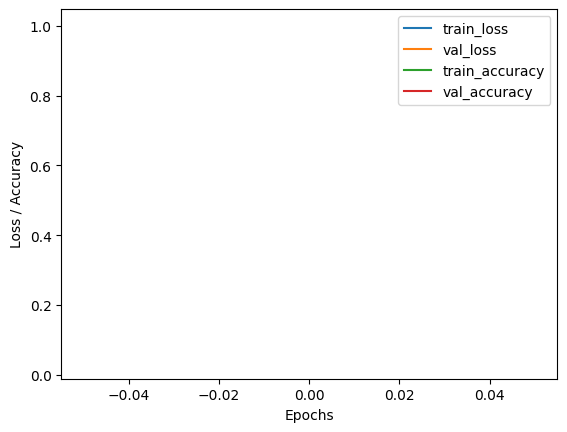

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
print(signals_train_reshaped.shape, labels_train.shape, (input_shape[-1], 1))

signals_train_reshaped = signals_train.reshape(signals_train.shape[0], signals_train.shape[1], 1)
history = model.fit(signals_train_reshaped, labels_train, validation_data=(signals_val, labels_val), epochs=1, batch_size=32, callbacks=[early_stopping])

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()


In [70]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(signals_test, labels_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

225/225 [==============================] - 28s 126ms/step - loss: 0.0369 - accuracy: 1.0000
Test Loss: 0.03687215968966484
Test Accuracy: 1.0


225/225 [==============================] - 28s 119ms/step


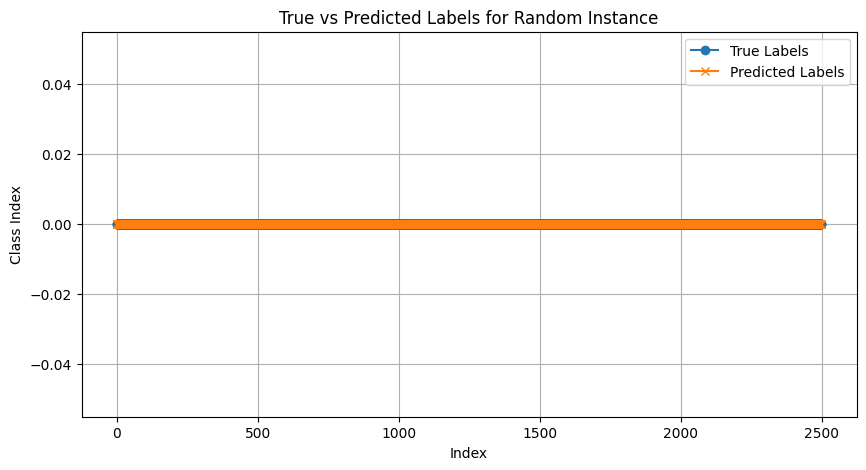

In [72]:
predictions = model.predict(signals_test)
predicted_indices = np.argmax(predictions, axis=2)

random_index = np.random.randint(0, len(signals_test))
true_labels = labels_test[random_index]
predicted_labels = predicted_indices[random_index]

# Convert true and predicted labels from one-hot encoded format to class indices
true_labels_indices = np.argmax(true_labels, axis=1)

# Plotting
plt.figure(figsize=(10, 5))

plt.plot(true_labels_indices, label='True Labels', marker='o')
plt.plot(predicted_labels, label='Predicted Labels', marker='x')
plt.xlabel('Index')
plt.ylabel('Class Index')
plt.title('True vs Predicted Labels for Random Instance')
plt.legend()
plt.grid(True)
plt.show()



According to the recommendations of the Association for Medical Instrumen-
tation [1], it is considered that an onset or an offset are detected correctly, if
their deviation from the doctor annotations does not exceed in absolute value
the tolerance of 150 ms.